Fingerprint dataset has 20592 files
Iris dataset has 5471 files
Voice dataset has 515 files


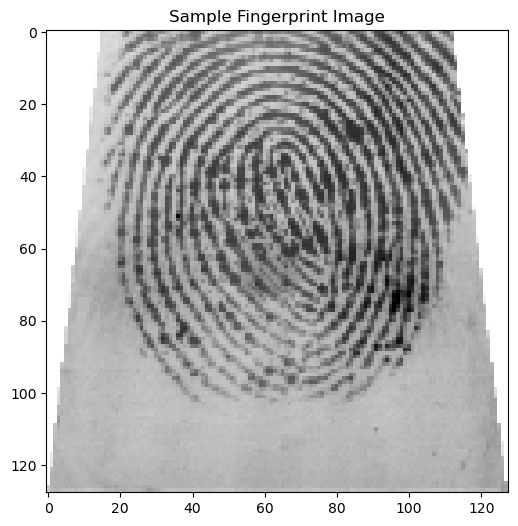

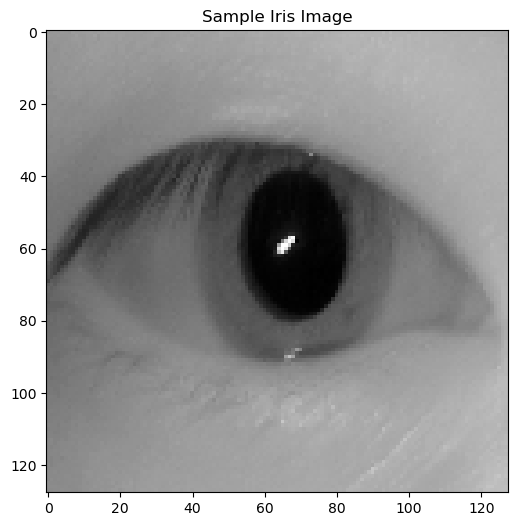

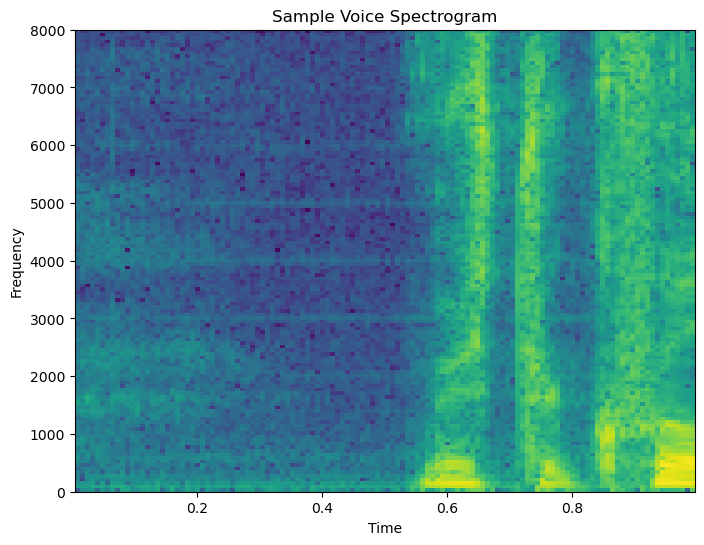

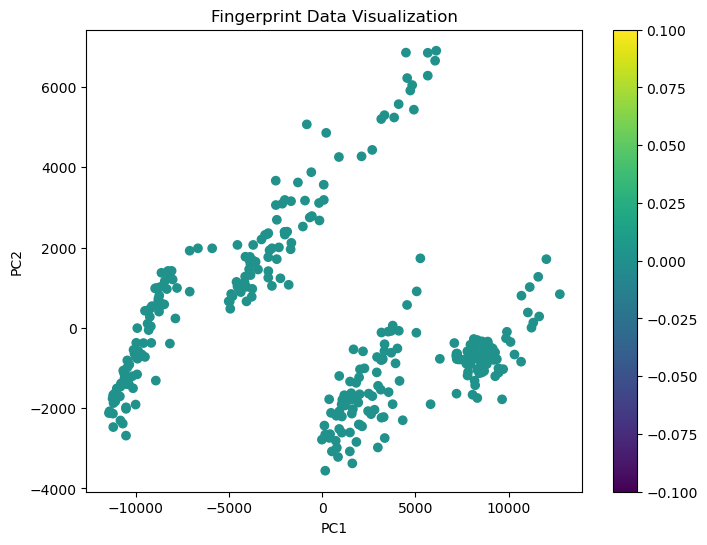

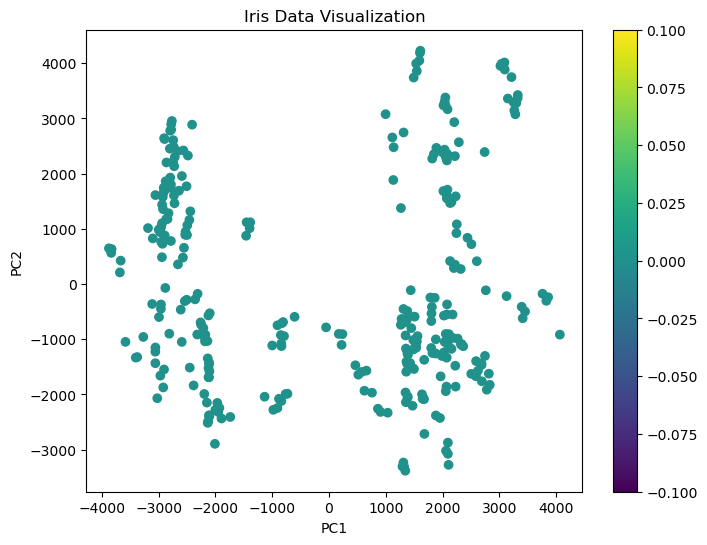

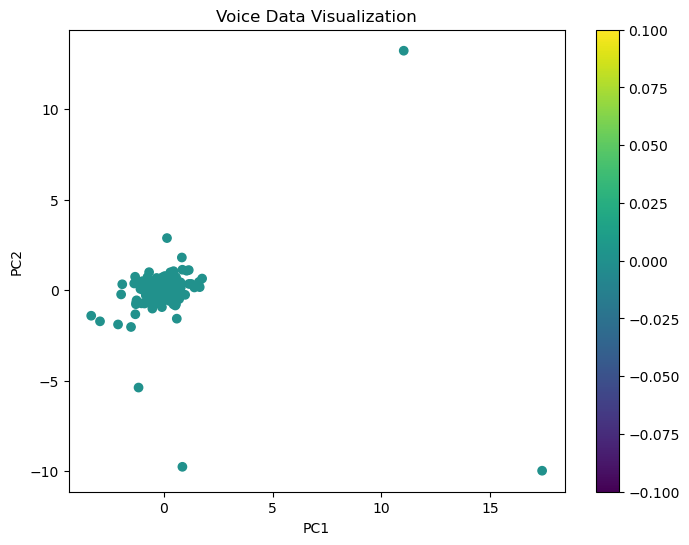

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 608ms/step - accuracy: 0.1267 - loss: 969.8701 - val_accuracy: 0.0938 - val_loss: 671.8439
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.2527 - loss: 644.9238 - val_accuracy: 0.2969 - val_loss: 367.9280
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.3901 - loss: 329.8913 - val_accuracy: 0.5000 - val_loss: 153.2336
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.5592 - loss: 93.5025 - val_accuracy: 0.7656 - val_loss: 40.8261
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.8445 - loss: 13.6861 - val_accuracy: 0.8125 - val_loss: 17.0594
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9206 - loss: 5.9231 - val_accuracy: 0.9062 - val_loss: 6.8188
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9762 - loss: 0.7841 - val_accuracy: 0.9375 - val_loss: 3.3491
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9917 - loss: 0.5458 - val_accuracy: 0.9375 -

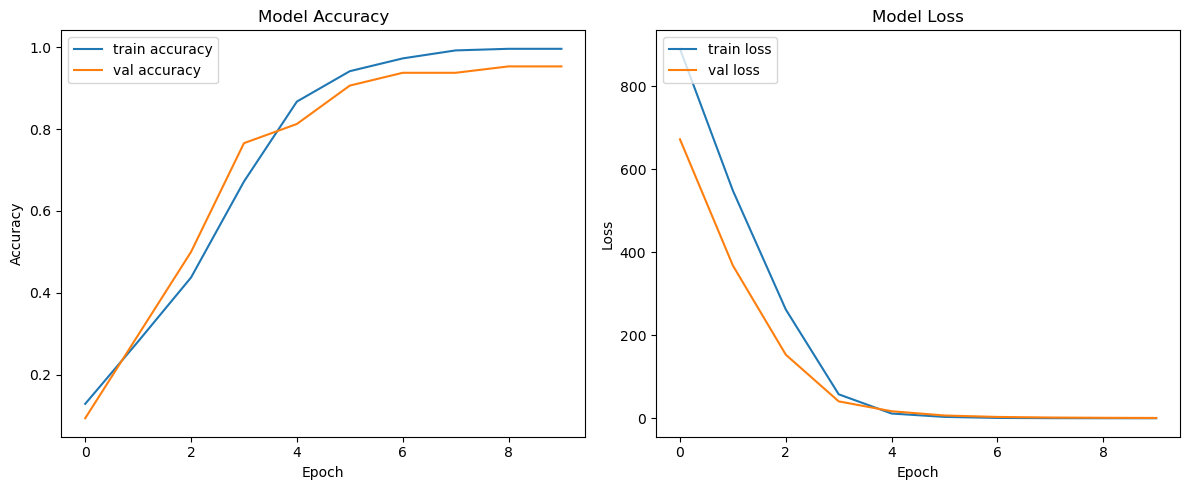

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 662ms/step


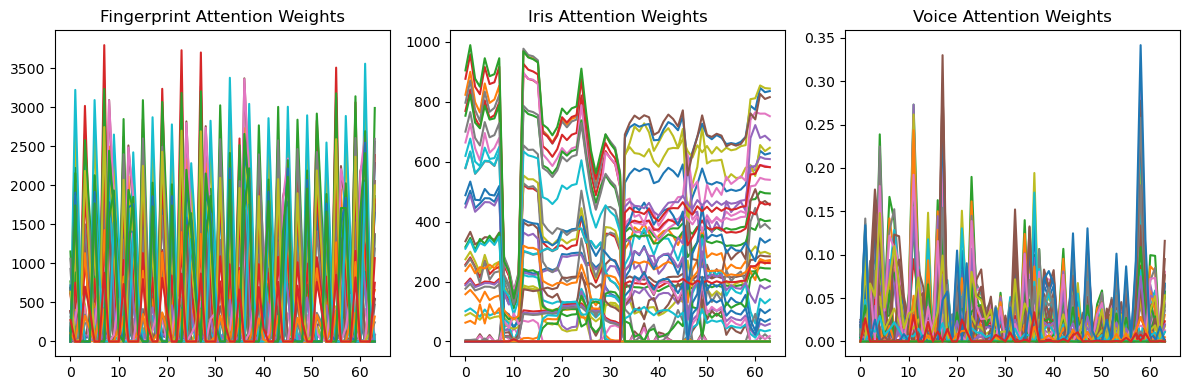

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


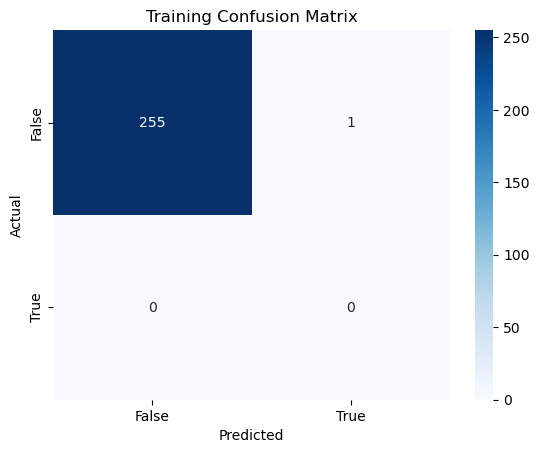

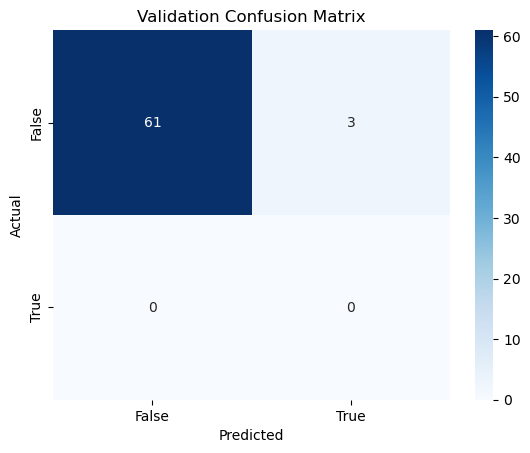

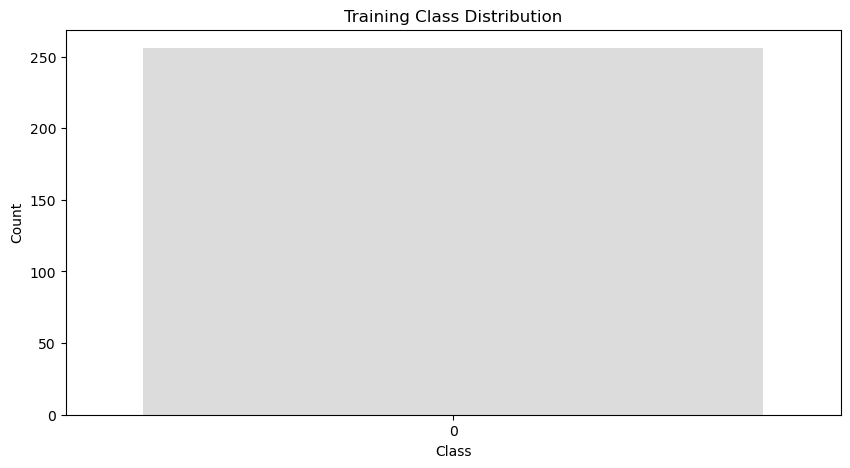

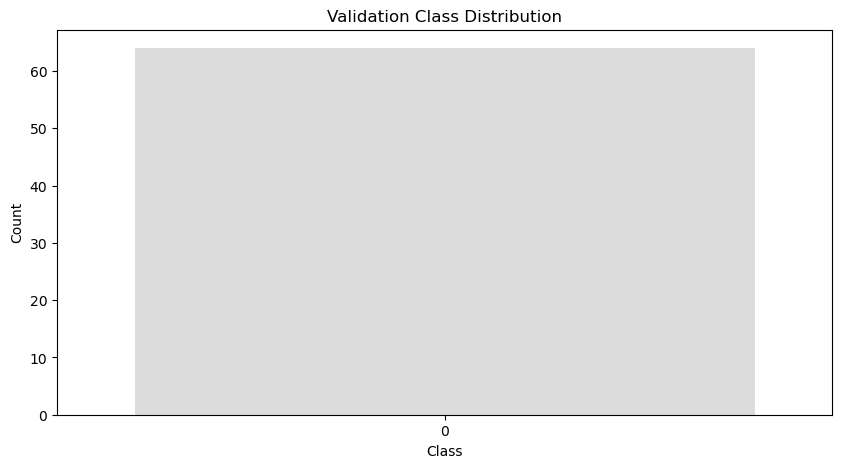

Training Classification Report:


NameError: name 'classification_report' is not defined

In [5]:
import os
import numpy as np
import cv2
import librosa
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Concatenate, Multiply, Dropout, Softmax
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set the paths to your local datasets
fingerprint_dataset_path = 'DB1_B'
iris_dataset_path = 'CASIA-Iris/001'
voice_dataset_path = 'LibriSpeech/dev-clean/84/121123'

def count_files(directory):
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len(files)
    return total_files

fingerprint_file_count = count_files(fingerprint_dataset_path)
iris_file_count = count_files(iris_dataset_path)
voice_file_count = count_files(voice_dataset_path)

print(f"Fingerprint dataset has {fingerprint_file_count} files")
print(f"Iris dataset has {iris_file_count} files")
print(f"Voice dataset has {voice_file_count} files")

# Preprocess fingerprint image
def preprocess_fingerprint(filepath):
    fingerprint_image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    fingerprint_image = cv2.resize(fingerprint_image, (128, 128))
    return fingerprint_image.flatten()

# Preprocess iris image
def preprocess_iris(filepath):
    iris_image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    iris_image = cv2.resize(iris_image, (128, 128))
    return iris_image.flatten()

# Preprocess voice data
def preprocess_voice(filepath, fixed_length=16000):
    voice_signal, _ = librosa.load(filepath, sr=16000)
    if len(voice_signal) > fixed_length:
        voice_signal = voice_signal[:fixed_length]
    else:
        voice_signal = np.pad(voice_signal, (0, max(0, fixed_length - len(voice_signal))), 'constant')
    return voice_signal

# Load and preprocess data
def load_data():
    fingerprint_data = []
    iris_data = []
    voice_data = []
    labels = []

    # Load fingerprint data
    for root, dirs, files in os.walk(fingerprint_dataset_path):
        for file in files:
            if file.endswith('.bmp') or file.endswith('.tif'):
                fingerprint_data.append(preprocess_fingerprint(os.path.join(root, file)))
                labels.append('person1') 
    # Load iris data
    for root, dirs, files in os.walk(iris_dataset_path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png') or file.endswith('.bmp'):
                iris_data.append(preprocess_iris(os.path.join(root, file)))
                labels.append('person1')  # Replace with actual labels

    # Load voice data
    for root, dirs, files in os.walk(voice_dataset_path):
        for file in files:
            if file.endswith('.flac'):
                voice_data.append(preprocess_voice(os.path.join(root, file)))
                labels.append('person1')  # Replace with actual labels

    # Ensure consistent lengths
    min_length = min(len(fingerprint_data), len(iris_data), len(voice_data))
    fingerprint_data = fingerprint_data[:min_length]
    iris_data = iris_data[:min_length]
    voice_data = voice_data[:min_length]
    labels = labels[:min_length]

    fingerprint_data = np.array(fingerprint_data)
    iris_data = np.array(iris_data)
    voice_data = np.array(voice_data)

    # Encode labels
    le = LabelEncoder()
    labels = le.fit_transform(labels)

    return fingerprint_data, iris_data, voice_data, labels

# Visualize original data
def visualize_original_data(fingerprint_data, iris_data, voice_data, labels):
    # Fingerprint data visualization
    plt.figure(figsize=(8, 6))
    plt.scatter(fingerprint_data[:, 0], fingerprint_data[:, 1], c=labels, cmap='viridis')
    plt.title('Fingerprint Data Visualization')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar()
    plt.show()

    # Iris data visualization
    plt.figure(figsize=(8, 6))
    plt.scatter(iris_data[:, 0], iris_data[:, 1], c=labels, cmap='viridis')
    plt.title('Iris Data Visualization')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar()
    plt.show()

    # Voice data visualization
    plt.figure(figsize=(8, 6))
    plt.scatter(voice_data[:, 0], voice_data[:, 1], c=labels, cmap='viridis')
    plt.title('Voice Data Visualization')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar()
    plt.show()

# Visualize sample images
def display_sample_images(fingerprint_data, iris_data, voice_data):
    # Display a sample fingerprint image
    if len(fingerprint_data) > 0:
        sample_fingerprint_image = fingerprint_data[0].reshape(128, 128)
        plt.figure(figsize=(6, 6))
        plt.imshow(sample_fingerprint_image, cmap='gray')
        plt.title('Sample Fingerprint Image')
        plt.show()
    else:
        print("Fingerprint data is empty. Skipping fingerprint image display.")

    # Display a sample iris image
    if len(iris_data) > 0:
        sample_iris_image = iris_data[0].reshape(128, 128)
        plt.figure(figsize=(6, 6))
        plt.imshow(sample_iris_image, cmap='gray')
        plt.title('Sample Iris Image')
        plt.show()
    else:
        print("Iris data is empty. Skipping iris image display.")

    # Display a sample voice spectrogram
    if len(voice_data) > 0:
        sample_voice_data = voice_data[0]
        plt.figure(figsize=(8, 6))
        plt.specgram(sample_voice_data, Fs=16000)
        plt.title('Sample Voice Spectrogram')
        plt.xlabel('Time')
        plt.ylabel('Frequency')
        plt.show()
    else:
        print("Voice data is empty. Skipping voice spectrogram display.")

# Reduce dimensionality of the features
def reduce_dimensionality(features, n_components=2):
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)
    return reduced_features

# Define attention mechanism
def attention_layer(inputs, attention_dim=16):
    concat_inputs = Concatenate()(inputs)
    attention_weights = Dense(attention_dim, activation='relu')(concat_inputs)
    attention_weights = Dense(len(inputs), activation='softmax')(attention_weights)
    weighted_inputs = [Multiply()([inputs[i], attention_weights[:, i:i+1]]) for i in range(len(inputs))]
    return weighted_inputs


def create_model(fingerprint_dim, iris_dim, voice_dim):
    # Define regularization strength
    l2_strength = 0.01  # You can adjust this value as needed

    # Fingerprint input
    fingerprint_input = Input(shape=(fingerprint_dim,), name='fingerprint_input')
    fingerprint_layer = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_strength), name='fingerprint_dense')(fingerprint_input)

    # Iris input
    iris_input = Input(shape=(iris_dim,), name='iris_input')
    iris_layer = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_strength), name='iris_dense')(iris_input)

    # Voice input
    voice_input = Input(shape=(voice_dim,), name='voice_input')
    voice_layer = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_strength), name='voice_dense')(voice_input)

    # Attention mechanism
    weighted_fingerprint, weighted_iris, weighted_voice = attention_layer([fingerprint_layer, iris_layer, voice_layer])

    # Fused features
    fused_features = Concatenate(name='fused_features')([weighted_fingerprint, weighted_iris, weighted_voice])

    # Output layer
    output = Dense(1, activation='sigmoid', name='output')(fused_features)

    model = tf.keras.Model(inputs=[fingerprint_input, iris_input, voice_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


# Train the model
def train_model(model, train_fingerprint_data, train_iris_data, train_voice_data, train_labels, test_fingerprint_data, test_iris_data, test_voice_data, test_labels):
    history = model.fit([train_fingerprint_data, train_iris_data, train_voice_data], train_labels,
                       epochs=10, batch_size=32, validation_data=([test_fingerprint_data, test_iris_data, test_voice_data], test_labels))

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate([test_fingerprint_data, test_iris_data, test_voice_data], test_labels)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Get the validation loss and validation accuracy
    val_loss = history.history['val_loss'][-1]
    val_accuracy = history.history['val_accuracy'][-1]

    return history, val_loss, val_accuracy

# Visualize attention weights
def visualize_attention_weights(model, test_fingerprint_data, test_iris_data, test_voice_data):
    attention_model = Model(model.inputs, [model.get_layer('fingerprint_dense').output,
                                          model.get_layer('iris_dense').output,
                                          model.get_layer('voice_dense').output,
                                          model.get_layer('fused_features').output])
    fingerprint_features, iris_features, voice_features, fused_features = attention_model.predict([test_fingerprint_data, test_iris_data, test_voice_data])

    # Visualize attention weights for each modality
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title('Fingerprint Attention Weights')
    plt.plot(fingerprint_features)
    plt.subplot(1, 3, 2)
    plt.title('Iris Attention Weights')
    plt.plot(iris_features)
    plt.subplot(1, 3, 3)
    plt.title('Voice Attention Weights')
    plt.plot(voice_features)
    plt.tight_layout()
    plt.show()
    

def plot_loss_and_accuracy(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    # Summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()



# Main function
def main():
    fingerprint_data, iris_data, voice_data, labels = load_data()

    # Display sample images
    display_sample_images(fingerprint_data, iris_data, voice_data)

    # Reduce dimensionality of the features
    reduced_fingerprint_data = reduce_dimensionality(fingerprint_data)
    reduced_iris_data = reduce_dimensionality(iris_data)
    reduced_voice_data = reduce_dimensionality(voice_data)

    # Visualize the reduced data
    visualize_original_data(reduced_fingerprint_data, reduced_iris_data, reduced_voice_data, labels)

    # Split data into training and testing sets
    train_split = 0.8
    num_samples = len(labels)
    num_train_samples = int(num_samples * train_split)

    train_fingerprint_data = reduced_fingerprint_data[:num_train_samples]
    test_fingerprint_data = reduced_fingerprint_data[num_train_samples:]
    train_iris_data = reduced_iris_data[:num_train_samples]
    test_iris_data = reduced_iris_data[num_train_samples:]
    train_voice_data = reduced_voice_data[:num_train_samples]
    test_voice_data = reduced_voice_data[num_train_samples:]
    train_labels = labels[:num_train_samples]
    test_labels = labels[num_train_samples:]

    # Create and train the model
    fingerprint_dim = train_fingerprint_data.shape[1]
    iris_dim = train_iris_data.shape[1]
    voice_dim = train_voice_data.shape[1]

    model = create_model(fingerprint_dim, iris_dim, voice_dim)
    history, val_loss, val_accuracy = train_model(model, train_fingerprint_data, train_iris_data, train_voice_data, train_labels, test_fingerprint_data, test_iris_data, test_voice_data, test_labels)
    plot_loss_and_accuracy(history)
    
    # Visualize attention weights
    visualize_attention_weights(model, test_fingerprint_data, test_iris_data, test_voice_data)
    
    # Generate predictions
    y_train_pred = (model.predict([train_fingerprint_data, train_iris_data, train_voice_data]) > 0.5).astype("int32")
    y_test_pred = (model.predict([test_fingerprint_data, test_iris_data, test_voice_data]) > 0.5).astype("int32")

    # Plot confusion matrices
    plot_confusion_matrix(train_labels, y_train_pred, 'Training Confusion Matrix')
    plot_confusion_matrix(test_labels, y_test_pred, 'Validation Confusion Matrix')
    # Plot class distribution
    plot_class_distribution(train_labels, test_labels)

    # Generate and print classification reports
    print("Training Classification Report:")
    print(classification_report(train_labels, y_train_pred))
    print("Validation Classification Report:")
    print(classification_report(test_labels, y_test_pred))




# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()
import seaborn as sns

# Function to plot class distribution
def plot_class_distribution(train_labels, test_labels):
    plt.figure(figsize=(10, 5))
    sns.countplot(x=train_labels, palette='coolwarm')
    plt.title('Training Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.countplot(x=test_labels, palette='coolwarm')
    plt.title('Validation Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()



if __name__ == "__main__":
    main()